In [1]:
import pandas as pd
import re
from hdbscan import HDBSCAN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import stanza
from bertopic import BERTopic
import ast
import string
sns.set_theme()

In [73]:
df = pd.read_csv('TKlemm0409v2.csv')

In [77]:
def load_stopwords():
    filepath = 'polish.stopwords.txt'
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip().lower() for line in f if line.strip())
    return stopwords

def clean_tokens(tokens):
    stop_words = load_stopwords()
    replacements = {
        'ipna': 'IPN',
        'vot': 'vat',
        'ceb': 'CBA'
    }
    cleaned = []
    for token in tokens:
        token_lower = token.lower()
        if token_lower in stop_words:
            continue
        if token_lower in string.punctuation:
            continue
        if token_lower.isdigit():
            continue
        if any(char.isdigit() for char in token_lower):
            continue
        # Zamiana słowa, jeśli jest w słowniku replacements
        token_replaced = replacements.get(token_lower, token_lower)
        cleaned.append(token_replaced)
    return cleaned

In [79]:
df['grounds_lem'] = df['grounds_lem'].apply(ast.literal_eval)
df['grounds_lem_cleaned'] = df['grounds_lem'].apply(clean_tokens)

In [81]:
docs = df['grounds_lem_cleaned'].apply(lambda tokens: ' '.join(tokens)).tolist()

In [89]:
hdbscan_model = HDBSCAN(min_cluster_size=2)
topic_model = BERTopic(language="polish", hdbscan_model=hdbscan_model, nr_topics = 10, n_gram_range = (1,3))
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic(0)

[('konstytucyjny', 0.011373939760456432),
 ('trybunał', 0.009571645091875042),
 ('móc', 0.009279746058952232),
 ('zakres', 0.009247355320997281),
 ('zasada', 0.00908243117140572),
 ('prawny', 0.009035376282446543),
 ('mieć', 0.008835079056110652),
 ('osoba', 0.008633354496452703),
 ('sąd', 0.008602510450113409),
 ('sprawa', 0.008099410143944942)]

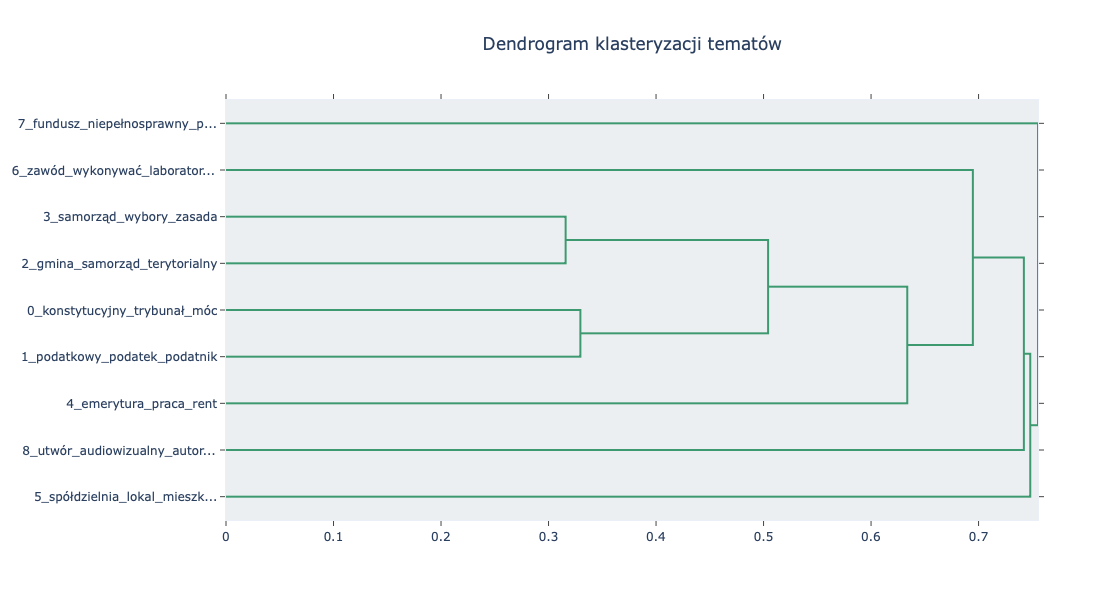

In [91]:
fig = topic_model.visualize_hierarchy(top_n_topics=50)
fig.update_layout(title='Dendrogram klasteryzacji tematów',title_x=0.7, height=600)

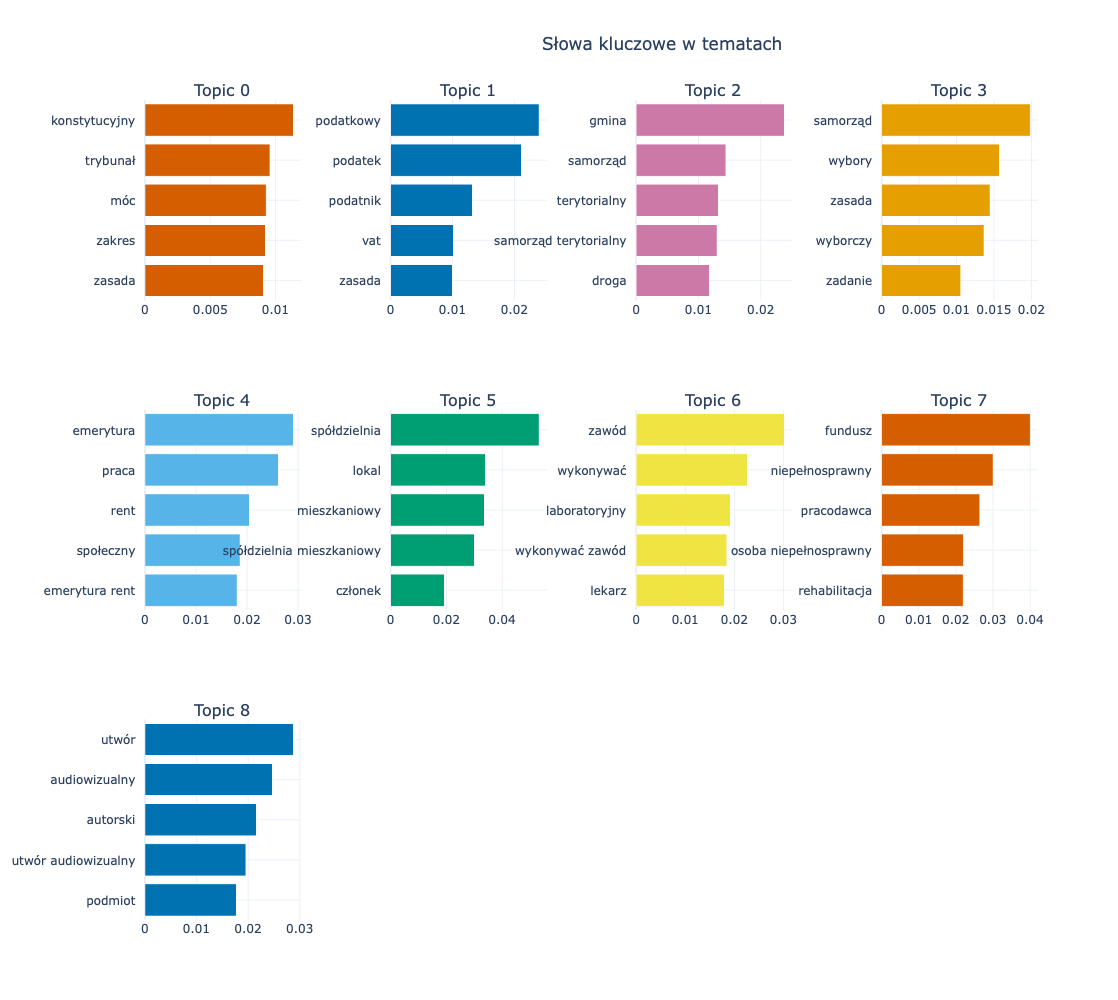

In [93]:
fig = topic_model.visualize_barchart(top_n_topics=25)
fig.update_layout(title='Słowa kluczowe w tematach',title_x=0.7, height=1000, width =1300)

In [9]:
fig = topic_model.visualize_heatmap(n_clusters=2, width=1000, height=1000)
fig.update_layout(title='Macierz podobieństw tematów',title_x=0.7)
fig.update_xaxes(tickangle=90)
fig.update_yaxes(tickangle=0)
fig.show()

In [15]:
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)

vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
X = vectorizer.fit_transform(docs)  
feature_names = vectorizer.get_feature_names_out()

tfidf_sum = np.asarray(X.sum(axis=0)).flatten()

# Tworzymy DataFrame: słowo + jego suma tf-idf
TFIDF = pd.DataFrame({
    'word': feature_names,
    'tfidf_sum': tfidf_sum
})

# Sortujemy i wybieramy top 20 słów
top_words = TFIDF.sort_values(by='tfidf_sum', ascending=False).head(10)
print(top_words)

                word  tfidf_sum
5672   konstytucyjny  18.247149
18560       trybunał  14.286222
23194         zasada  13.057242
9570           numer  12.519724
17214         sprawa  11.060636
22683         zakres  10.557284
7197             móc  10.410762
6925            mieć  10.400819
12704   postępowanie  10.119024
13415         prawny   9.925017
